# Exploring Shot Types 
Want to find out if certain shot types are more successful in 3on3 vs regulation

In [1]:
# general imports, may not use every one of these
import os
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

##### read in data for 2020-21 regular season

In [2]:
# years = ['2015','2016','2017','2018','2019','2020']
years = ['2015','2016','2017','2018','2019','2020']
games = {}
for year in years:
    path = os.getcwd()
    path = os.path.abspath(os.path.join(path, os.pardir, 'data/' + year + '_regSeasonPlays.json'))
    print(path)
    with open(path) as f:
        games[year] = json.load(f)

/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2015_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2016_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2017_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2018_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2019_regSeasonPlays.json
/Users/williamshaw/Projects/NHL/nhl_overtime_eda/data/2020_regSeasonPlays.json


#### get counts of each event type

In [3]:
counter = 0
event_types = {}

for year in games:
    for game_id, game in games[year].items():
#         if counter < 10:
        for event in game['events']:
            event_type = event['result']['event']
            if event_type is not None:
                if event_type in event_types:
                    event_types[event_type] += 1
                else:
                    event_types[event_type] = 1
                    
#         else:
#             break
        counter += 1
print('total games: ' + str(counter))
        

total games: 7139


In [4]:
pprint.pprint(event_types)

{'Blocked Shot': 195482,
 'Early Intermission End': 14,
 'Early Intermission Start': 14,
 'Emergency Goaltender': 6,
 'Faceoff': 409755,
 'Game End': 6942,
 'Game Official': 1883,
 'Game Scheduled': 6943,
 'Giveaway': 129411,
 'Goal': 40948,
 'Hit': 307460,
 'Missed Shot': 163726,
 'Official Challenge': 1060,
 'Penalty': 51604,
 'Period End': 22948,
 'Period Official': 22948,
 'Period Ready': 22953,
 'Period Start': 22982,
 'Shootout Complete': 574,
 'Shot': 390485,
 'Stoppage': 320937,
 'Takeaway': 96318}


Goals are not recorded as shots. Let's keep separate lists for shots and goals, but strucutre lists the same way.
Also, omit empty net goals

In [5]:
counter = 0
shots_count = 0
shots = []
goals = []
data_structure = {
    'shot_type': '',
    'x_coordinate': 0,
    'y_coordinate': 0,
    'period': 0,
    'period_type': '',
    'strength': '',
    'goal': False
}

for year in games:
    for game_id, game in games[year].items():
#         print(game_id)
        for event in game['events']:
            event_type = event['result']['event']
            if event_type == 'Shot' and event['about']['periodType'] != 'SHOOTOUT' and 'secondaryType' in event['result']:
                ds = data_structure.copy()
                ds['shot_type'] = event['result']['secondaryType']
                if 'x' in event['coordinates']: ds['x_coordinate'] = event['coordinates']['x']
                if 'y' in event['coordinates']: ds['y_coordinate'] = event['coordinates']['y']
                ds['period'] = event['about']['period']
                ds['period_type'] = event['about']['periodType']
                shots.append(ds)
            elif event_type == 'Goal' and event['about']['periodType'] != 'SHOOTOUT' and not event['result']['emptyNet']:
                ds = data_structure.copy()
                if 'secondaryType' in event['result']: ds['shot_type'] = event['result']['secondaryType']
                else: ds['shot_type'] = 'Penalty On Empty Net'
                if 'x' in event['coordinates']: ds['x_coordinate'] = event['coordinates']['x']
                if 'y' in event['coordinates']: ds['y_coordinate'] = event['coordinates']['y']
                ds['period'] = event['about']['period']
                ds['period_type'] = event['about']['periodType']
                ds['strength'] = event['result']['strength']['code']
                ds['goal'] = True
                goals.append(ds)
        counter += 1
print('total games: ' + str(counter))
        

total games: 7139


In [6]:
print(len(shots))
# pprint.pprint(goals)

388432


In [7]:
df_goals = pd.DataFrame.from_dict(goals)
print('goals df: ' + str(len(df_goals)) + ' entries')
display(df_goals.head())

df_shots = pd.DataFrame.from_dict(shots)
print('shots df: ' + str(len(df_shots)) + ' entries')
display(df_shots.head())

# goals need to be counted as shots too, append goals df to shots df
df_all = pd.concat([df_goals, df_shots])
print('goals and shots df: ' + str(len(df_all)) + ' entries')
display(df_all.head())

goals df: 37714 entries


,shot_type,x_coordinate,y_coordinate,period,period_type,strength,goal
0,Wrist Shot,63.0,-27.0,1,REGULAR,EVEN,True
1,Deflected,-73.0,-1.0,2,REGULAR,PPG,True
2,Snap Shot,67.0,0.0,3,REGULAR,EVEN,True
3,Wrist Shot,82.0,-21.0,1,REGULAR,EVEN,True
4,Wrist Shot,-77.0,2.0,1,REGULAR,EVEN,True


shots df: 388432 entries


,shot_type,x_coordinate,y_coordinate,period,period_type,strength,goal
0,Wrist Shot,-55.0,6.0,1,REGULAR,,False
1,Snap Shot,-79.0,0.0,1,REGULAR,,False
2,Snap Shot,-75.0,-1.0,1,REGULAR,,False
3,Wrist Shot,-55.0,-36.0,1,REGULAR,,False
4,Tip-In,-61.0,-1.0,1,REGULAR,,False


goals and shots df: 426146 entries


,shot_type,x_coordinate,y_coordinate,period,period_type,strength,goal
0,Wrist Shot,63.0,-27.0,1,REGULAR,EVEN,True
1,Deflected,-73.0,-1.0,2,REGULAR,PPG,True
2,Snap Shot,67.0,0.0,3,REGULAR,EVEN,True
3,Wrist Shot,82.0,-21.0,1,REGULAR,EVEN,True
4,Wrist Shot,-77.0,2.0,1,REGULAR,EVEN,True


In [8]:
df_all[df_all['goal']==True]['period'].value_counts()

2    13582
3    11679
1    11425
4     1028
Name: period, dtype: int64

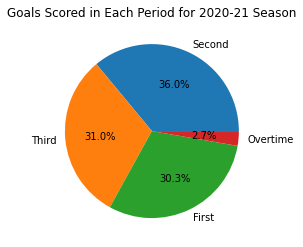

In [9]:
my_data = df_all[df_all['goal']==True]['period'].value_counts()
my_labels = ['Second', 'Third', 'First', 'Overtime']
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%')
plt.title('Goals Scored in Each Period for 2020-21 Season')
plt.show()

#### Compare success rates of each shot type for regulation and overtime period types

In [10]:
# split data into regulation and overtime dataframes
df_reg = df_all[df_all['period_type']=='REGULAR']
df_ot = df_all[df_all['period_type']=='OVERTIME']

In [11]:
# df_reg[df_reg['goal']==True]['shot_type'].value_counts()

display(df_reg[df_reg['goal']==True]['shot_type'].value_counts())
display(df_reg[df_reg['goal']==False]['shot_type'].value_counts())

Wrist Shot              18210
Snap Shot                5661
Slap Shot                4089
Tip-In                   3727
Backhand                 3481
Deflected                1216
Wrap-around               278
Penalty On Empty Net       24
Name: shot_type, dtype: int64

Wrist Shot     206994
Slap Shot       63058
Snap Shot       55328
Backhand        29814
Tip-In          17694
Deflected        5930
Wrap-around      4008
Name: shot_type, dtype: int64

In [12]:
display(df_ot[df_ot['goal']==True]['shot_type'].value_counts().sort_index())
display(df_ot[df_ot['goal']==False]['shot_type'].value_counts().sort_index())

Backhand       117
Deflected       12
Slap Shot      116
Snap Shot      177
Tip-In          52
Wrap-around      9
Wrist Shot     545
Name: shot_type, dtype: int64

Backhand        586
Deflected        40
Slap Shot       712
Snap Shot       867
Tip-In          166
Wrap-around      45
Wrist Shot     3190
Name: shot_type, dtype: int64

In [13]:
df_reg[df_reg['goal']==True]['shot_type'].value_counts().sort_index()

Backhand                 3481
Deflected                1216
Penalty On Empty Net       24
Slap Shot                4089
Snap Shot                5661
Tip-In                   3727
Wrap-around               278
Wrist Shot              18210
Name: shot_type, dtype: int64

In [14]:
df_prop = pd.DataFrame()

# get rates of success for shot types in regulation
df_prop['reg_success'] = df_reg[df_reg['goal']==True]['shot_type'].value_counts().sort_index()
df_prop['reg_failure'] = df_reg[df_reg['goal']==False]['shot_type'].value_counts().sort_index()
df_prop['reg_rate'] = df_prop['reg_success'] / df_prop['reg_failure']

# get rates of success for shot types in overtime
df_prop['ot_success'] = df_ot[df_ot['goal']==True]['shot_type'].value_counts().sort_index()
df_prop['ot_failure'] = df_ot[df_ot['goal']==False]['shot_type'].value_counts().sort_index()
df_prop['ot_rate'] = df_prop['ot_success'] / df_prop['ot_failure']

# drop 'Penalty On Empty Net' row
df_prop.drop(labels='Penalty On Empty Net', axis=0, inplace=True)

df_prop

,reg_success,reg_failure,reg_rate,ot_success,ot_failure,ot_rate
Backhand,3481,29814.0,0.116757,117.0,586.0,0.199659
Deflected,1216,5930.0,0.205059,12.0,40.0,0.300000
Slap Shot,4089,63058.0,0.064845,116.0,712.0,0.162921
Snap Shot,5661,55328.0,0.102317,177.0,867.0,0.204152
Tip-In,3727,17694.0,0.210636,52.0,166.0,0.313253
Wrap-around,278,4008.0,0.069361,9.0,45.0,0.200000
Wrist Shot,18210,206994.0,0.087974,545.0,3190.0,0.170846


In [15]:
chi2, p, dof, ex = stats.chi2_contingency(df_prop[['reg_success', 'ot_success']].values, correction=False)


In [17]:
print('chi-squared val: ' + str(chi2))
print('p-val: ' + str(p))
print('degrees of freedom: ' + str(dof))
print('table of expected values:')
df_ex = df_prop[['reg_success', 'ot_success']].copy()
df_ex_tmp = pd.DataFrame(ex)
df_ex_tmp.columns = ['expected_reg_success', 'expected_ot_success']
df_ex['expected_reg_success'] = df_ex_tmp['expected_reg_success'].to_list()
df_ex['expected_ot_success'] = df_ex_tmp['expected_ot_success'].to_list()
df_ex

chi-squared val: 48.40715492486193
p-val: 9.797096904316382e-09
degrees of freedom: 6
table of expected values:


,reg_success,ot_success,expected_reg_success,expected_ot_success
Backhand,3481,117.0,3499.864049,98.135951
Deflected,1216,12.0,1194.506129,33.493871
Slap Shot,4089,116.0,4090.308039,114.691961
Snap Shot,5661,177.0,5678.767737,159.232263
Tip-In,3727,52.0,3675.927249,103.072751
Wrap-around,278,9.0,279.172035,7.827965
Wrist Shot,18210,545.0,18243.454763,511.545237


##### Chi-square test of homogeneity of successful shot types in regulation and overtime scenarios
Testing to see if certain types of shots are more successful in overtime vs regulation.

$$
H_0: \begin{align*} Proportion_{regulation\hspace{1pt}backhand\hspace{1pt}goals} = Proportion_{overtime\hspace{1pt}backhand\hspace{1pt}goals} \\
Proportion_{regulation\hspace{1pt}deflected\hspace{1pt}goals} = Proportion_{overtime\hspace{1pt}deflected\hspace{1pt}goals} \end{align*}
\\
...\\
$$

$$
H_a: \begin{align*} Proportion_{regulation\hspace{1pt}backhand\hspace{1pt}goals} \neq Proportion_{overtime\hspace{1pt}backhand\hspace{1pt}goals} \\
Proportion_{regulation\hspace{1pt}deflected\hspace{1pt}goals} \neq Proportion_{overtime\hspace{1pt}deflected\hspace{1pt}goals} \end{align*}
\\
...\\
$$

$$
\alpha = 0.05
$$

Where observed and expected values follow:

| Shot Type      | Observed Regulation Goals | Observed Overtime Goals | Expected Regulation Goals | Expected Overtime Goals |
| ----------- | ----------- | ----------- | ----------- | ----------- | 
| Backhand    | 3481  | 117 | 3500  | 98  |
| Deflected   | 1216  | 12  | 1194  | 33  |
| Slap Shot   | 4089  | 116 | 4090  | 115 |
| Snap Shot   | 5661  | 177 | 5679  | 159 |
| Tip-In      | 3727  | 52  | 3676  | 103 |
| Wrap-around | 278   | 9   | 279   | 8   |
| Wrist Shot  | 18210 | 545 | 18243 | 512 |

And test statistics follow:
$$
{\chi}^2 = 48.01 \\
df = 6 \\
p < 0.00001
$$

Conclusion:
$$
\text{Since } p \lt \alpha \text{, we  reject } H_0\text{. Between the 2015-16 and 2020-21 seasons,} \\ 
\text{there is enough evidence to say there is a difference between the proportion of successful shot types in regulation vs overtime.} 
$$

#### Create a bar chart showing observed vs expected

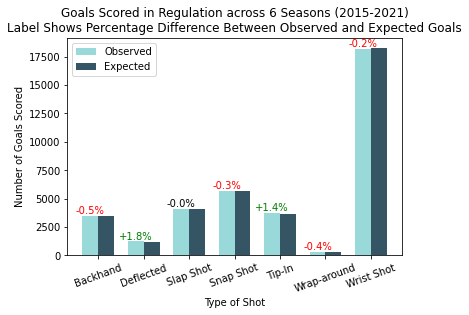

In [127]:
# grab labels, obs, and exp values for regulation goals
items = df_prop.index.values
observed = df_ex['reg_success'].to_list()
expected = df_ex['expected_reg_success'].to_list()

# initialize fig
fig, ax = plt.subplots()

# plot obs and expected
width = 0.35
N = 7
ind = np.arange(N) 
p1 = ax.bar(ind, observed, width=width, label='Observed', color='#99D9D9')
p2 = ax.bar(ind+width, expected, width=width, label='Expected', color='#355464')

# adjust labels
ax.set_ylabel('Number of Goals Scored')
ax.set_xlabel('Type of Shot')
ax.set_title('Goals Scored in Regulation across 6 Seasons (2015-2021)\n' + 
                 'Label Shows Percentage Difference Between Observed and Expected Goals')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(items, rotation = 20)
ax.legend(loc='best')

# create labels
rects = ax.patches
labels = []
for i in range(len(observed)):
    labels.append(round((observed[i] - expected[i]) / expected[i] * 100,1))


# apply labels
for rect, label in zip(rects, labels):
    height = rect.get_height()
    if label > 0: 
        text_color = 'green'
        label = '+' + str(label)
    elif label < 0: 
        text_color = 'red'
    else:
        text_color = 'black'
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)
plt.show()

# save figure to storage
fname = 'images/obsVexp_regulation.png'
fig.savefig(fname, bbox_inches="tight")

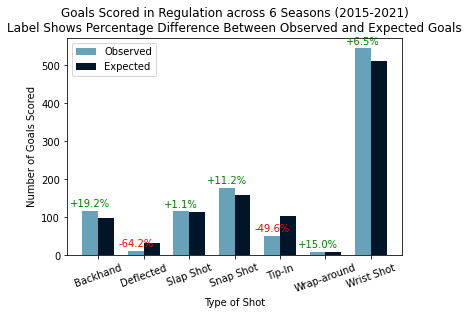

In [128]:
# grab labels, obs, and exp values for regulation goals
items = df_prop.index.values
observed = df_ex['ot_success'].to_list()
expected = df_ex['expected_ot_success'].to_list()

# initialize fig
fig, ax = plt.subplots()

# plot obs and expected
width = 0.35
N = 7
ind = np.arange(N) 
p1 = ax.bar(ind, observed, width=width, label='Observed', color='#68A2B9')
p2 = ax.bar(ind+width, expected, width=width, label='Expected', color='#001628')

# adjust labels
ax.set_ylabel('Number of Goals Scored')
ax.set_xlabel('Type of Shot')
ax.set_title('Goals Scored in Regulation across 6 Seasons (2015-2021)\n' + 
                 'Label Shows Percentage Difference Between Observed and Expected Goals')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(items, rotation = 20)
ax.legend(loc='best')

# create labels
rects = ax.patches
labels = []
for i in range(len(observed)):
    labels.append(round((observed[i] - expected[i]) / expected[i] * 100,1))

# apply labels
for rect, label in zip(rects, labels):
    height = rect.get_height()
    if label > 0: 
        text_color = 'green'
        label = '+' + str(label)
    else: 
        text_color = 'red'
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, str(label)+'%',
            ha='center', va='bottom', color=text_color)
plt.show()

# save figure to storage
fname = 'images/obsVexp_overtime.png'
fig.savefig(fname, bbox_inches="tight")